In [3]:
import pickle
import numpy as np
from re import split
import matplotlib.pyplot as plt

## create a dataset with a 'cluster' field

In [4]:
data = pickle.load(open("data/emotype_v10_val.p", "rb" ))

label_cluster_dict = {'addiction':0, 'anxiety':1, 'autism':2, 
                         'bipolar':3, 'conversation':4, 'depression':5, 
                         'happy':6, 'schizophrenia':7}

def initialize_cluster(data_dict, label_cluster_dict):
    """Initialize dictionary of OPs with cluster labels according original topic. """
    for i in range(len(data_dict)):
        data_dict[i]['cluster'] = label_cluster_dict[data_dict[i]['label']]
    return data_dict

data = initialize_cluster(data, label_cluster_dict)
color_map = plt.cm.get_cmap(name='tab10', lut=None).colors

## TFIDF
#### short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document/class in a collection or corpus (many classes/documents). Here we use the class interchangeably with document. 

### First, TF and IDF are measured for a single word

#### TF = term requency 

$$ TF_w = \frac{\text{word count in class}}{\text{total word count in that class including repeats}} $$

#### IDF = inverse document frequency

$$ IDF_w = \log{\frac{\text{number of classes}}{\text{total number of classes tha word appears in} + \epsilon}} $$

### then TF is multiplied with IDF

$$ TFIDF_w = TF_w \cdot IDF_w $$

In [5]:
class tfidf():
    
    def __init__(self, data, label_cluster_dict, debug_mode=False):
        self.data = data  # Dictionary with keys corresponding to OPs (values are also dicts)
        self.label_cluster_dict = label_cluster_dict
        self.tfidf_mat = None
        self.word_freq_mat = None
        print('Initializing count dict...')
        self.overall_count_dict = self.initialize_overall_count_dict(data)
        self.word_list = list(self.overall_count_dict.keys())
        print('Making tf-idf Matrix...')
        self.make_tfidf_mat()
        if debug_mode == True:
            print('Filling in the frequency dictionaries for debugging...')
            self.by_cluster_count_dict = {k:{} for k in self.overall_count_dict.keys()}
            self.by_cluster_tf_dict = {k:{} for k in self.overall_count_dict.keys()}
            self.idf_dict = {k:{} for k in self.overall_count_dict.keys()}
            self.by_cluster_tfidf_dict = {k:{} for k in self.overall_count_dict.keys()}
            self.fill_in_dicts()
            self.save_pickle_dicts()
    
    def phrase_to_tokens(self, phrase):
        """Takes in a (str) phrase and turns it into standardized tokens 
        """
        phrase = phrase.strip()
        phrase = phrase.lower()
        phrase = phrase.replace("'", "")  # Get rid of apostrophes
        list_of_words_in_phrase = split("[^a-zA-Z]+", phrase)  # split phrase into words/tokens
        return list_of_words_in_phrase
        
    def initialize_overall_count_dict(self, data):
        """ Returns a dictionary with keys corresponding to the set of words in data and values = 0
        """
        lexicon = []
        for i in range(len(data)):  # For every phrase in our data
            ith_phrase = data[i]['text']  # Get text from ith phrase 
            list_of_words_in_phrase = self.phrase_to_tokens(ith_phrase)
            lexicon.extend(list_of_words_in_phrase)  # Add all of the text's words to lexicon
        lexicon = set(lexicon)
        count_dict = {}.fromkeys(lexicon, 0)  # Create an empty dictionary from the set of words
        return count_dict
        
    def find_list_of_words_in_cluster(self, cluster_idx):
        '''input: class index (integer)
           output: list of phrases in that cluster where each phrase is itself a list of word strings
        '''
        str_list = []
        for i in range(len(data)):
            if data[i]['cluster'] == cluster_idx:
                words_in_ith_phrase = self.phrase_to_tokens(data[i]['text'])
                str_list.extend(words_in_ith_phrase)
        return str_list
    
    def calculate_cluster_word_freqs(self, list_of_words_in_cluster):
        '''returns a dictionary of counts for each word in the vocabulary'''
        cluster_word_count_dict = dict.fromkeys(self.overall_count_dict, 0)  # make a copy of dic, prefilled wi 0 count
        for word in list_of_words_in_cluster:
            if word: cluster_word_count_dict[word] += 1 # if string is not empty,'', increment count
        return cluster_word_count_dict
    
    def get_cluster_word_freq_vectors(self, list_of_words_in_cluster, cluster_word_count_dict):
        '''input: list of strings and dictionary of word counts
           output: vector of integers representing counts for each word in wordlist'''
        word_freqs = []
        for word in cluster_word_count_dict.keys():
            word_freqs.append(cluster_word_count_dict[word])
        return word_freqs

    def extract_vectors(self, cluster):
        list_of_words_in_cluster = self.find_list_of_words_in_cluster(cluster)
        cluster_word_count_dict = self.calculate_cluster_word_freqs(list_of_words_in_cluster)
        cluster_word_freq_vector = self.get_cluster_word_freq_vectors(list_of_words_in_cluster, 
                                                                      cluster_word_count_dict)
        return cluster_word_freq_vector
    
    def make_tfidf_mat(self):
    
        num_clusters = len(self.label_cluster_dict)  
        num_words_in_lexicon = len(self.word_list)

        # Rows are clusters, columns are words, and elements are word frequencies in the cluster
        self.word_freq_mat = np.zeros((num_clusters, num_words_in_lexicon))  # < number of classes, vocab size >
        
        for cluster_name, cluster_label in self.label_cluster_dict.items():
            cluster_freqs = np.array(self.extract_vectors(cluster_label))
            self.word_freq_mat[cluster_label, :] = cluster_freqs
        
        # a matrix where each element is the term frequency for the word of the same index 
        # the count is divided by the sum over the row, TF = the word_count/total_word_count
        
        self.tf = self.word_freq_mat / np.sum(self.word_freq_mat, axis=1, keepdims=True)

        # axis = 1 means you sum across the row and you are left with a column

        epsilon = 0.0001 # smoothing constant 
        # a vector of size vocab_size, where each element is the number of clusters/docs/classes 
        # that has greater than 0 instances of the word that has the same index as that element 

        num_clusters_with_word_present = np.sum(self.word_freq_mat > 0, axis=0, keepdims=True)

        # num_clusters_with_word_present.shape # (1, vocab_size)

        self.idf = np.log(num_clusters / (num_clusters_with_word_present + epsilon))

        self.tfidf_mat = self.tf * self.idf 

        # tfidf.shape = (num_classes, vocab_size)

    def fill_in_dicts(self):
        word_list_array = np.array(self.word_list)
        words_iter = 0
        for word in self.word_list:
            if words_iter % 1000 == 0:
                print('Running word {}'.format(words_iter))
            for cluster_name, cluster_label in self.label_cluster_dict.items():
                word_indx = np.where(word_list_array == word)
                word_freq_in_cluster = int(self.word_freq_mat[cluster_label, word_indx])
                self.by_cluster_count_dict[cluster_name][word] = word_freq_in_cluster
                self.overall_count_dict[word] += word_freq_in_cluster
                self.by_cluster_tf_dict[cluster_name][word] = float(self.tf[cluster_label, word_indx])
                self.by_cluster_tfidf_dict[cluster_name][word] = \
                    float(self.tfidf_mat[cluster_label, word_indx])
                self.idf_dict[cluster_name][word] = float(self.idf[:, word_indx])
            words_iter += 1
            
    def save_pickle_dicts(self):
        """Save down the frequency dicts if you're in debug mode
        """
        p = pickle.HIGHEST_PROTOCOL
        with open('emotype_v10_by_cluster_count_dict.p', 'wb') as handle:
            pickle.dump(self.by_cluster_count_dict, handle, protocol=p)
        with open('emotype_v10_overall_count_dict.p', 'wb') as handle:
            pickle.dump(self.overall_count_dict, handle, protocol=p)
        with open('emotype_v10_by_cluster_tf_dict.p', 'wb') as handle:
            pickle.dump(self.by_cluster_tf_dict, handle, protocol=p)
        with open('emotype_v10_by_idf_dict.p', 'wb') as handle:
            pickle.dump(self.idf_dict, handle, protocol=p)
        with open('emotype_v10_by_cluster_tfidf_dict.p', 'wb') as handle:
            pickle.dump(self.by_cluster_tfidf_dict, handle, protocol=p)
    
    def get_top_n_tfidf(self, n, cluster_idx, normalized=False):
        if self.tfidf_mat is None:   # if we haven't initialized our tf-idf matrix yet...
            print(" calculating tfidf...")
            self.make_tfidf_mat()  # ...then make it when the user asks for a specific label
        top_n_tfidf_word_indxs = np.argsort(self.tfidf_mat, axis=1)[:, -n:]
        top_n_word_indxs_for_cluster = list(top_n_tfidf_word_indxs[cluster_idx, :])
        top_n_tfidf_word_scores = self.tfidf_mat[cluster_idx, top_n_word_indxs_for_cluster]
        top_n_tfidf_words = [self.word_list[i] for i in top_n_word_indxs_for_cluster]
        if normalized:
            top_n_tfidf_word_scores = top_n_tfidf_word_scores / np.min(top_n_tfidf_word_scores)
            top_n_tfidf_word_scores *= 100
            top_n_tfidf_word_scores = np.array(top_n_tfidf_word_scores, dtype=int)
        return [(top_n_tfidf_words[i], top_n_tfidf_word_scores[i]) for i in range(n)]

In [6]:
tfidf_data = tfidf(data, label_cluster_dict)

Initializing count dict...
Making tf-idf Matrix...


In [7]:
tfidf_data.get_top_n_tfidf(30, label_cluster_dict['bipolar'], normalized=True)

[('abilify', 100),
 ('image', 100),
 ('wtf', 100),
 ('except', 100),
 ('stable', 100),
 ('seroquel', 100),
 ('upset', 101),
 ('episode', 133),
 ('diagnoses', 133),
 ('support', 135),
 ('distant', 149),
 ('peer', 149),
 ('click', 149),
 ('friendly', 149),
 ('depressive', 149),
 ('flip', 149),
 ('meds', 149),
 ('latuda', 166),
 ('psych', 166),
 ('manic', 166),
 ('join', 199),
 ('hypomania', 199),
 ('episodes', 199),
 ('lithium', 200),
 ('welcome', 249),
 ('discord', 299),
 ('hypomanic', 399),
 ('server', 449),
 ('bipolar', 799),
 ('bpd', 799)]

In [8]:
tfidf_data.get_top_n_tfidf(20, label_cluster_dict['depression'], normalized=True)

[('farther', 100),
 ('harming', 100),
 ('hurting', 100),
 ('celebrate', 100),
 ('takeaways', 100),
 ('goodbye', 100),
 ('noose', 100),
 ('respect', 100),
 ('urges', 100),
 ('consuming', 100),
 ('suicide', 100),
 ('depression', 103),
 ('miss', 113),
 ('suicidal', 117),
 ('kill', 124),
 ('exhausted', 133),
 ('deserve', 141),
 ('cried', 150),
 ('lonely', 166),
 ('didn', 166)]

In [9]:
def get_np_array_version_of_data_dict_elements(data):
    
    embeddings = np.zeros((len(data), data[0]['encoding'].shape[1]))
    outputs = np.zeros((len(data), data[0]['outputs'].shape[1]))
    true_labels = [None] * len(data)
    pred_labels = [None] * len(data)
    text = [None] * len(data)
    
    for k in data.keys():
        embeddings[k, :] = data[k]['encoding']
        outputs[k, :] = data[k]['outputs']
        true_labels[k] = data[k]['label']
        pred_labels[k] = data[k]['prediction']
        text[k] = data[k]['text']
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    text = np.array(text)
    
    return embeddings, outputs, true_labels, pred_labels, text 

In [10]:
npy_conversion_results = get_np_array_version_of_data_dict_elements(data)
embeddings, outputs, true_labels, pred_labels, text = npy_conversion_results

In [11]:
psycho_embeddings = embeddings[true_labels != 'conversation']
psycho_labels = true_labels[true_labels != 'conversation']
psycho_embeddings_no_dep = psycho_embeddings[psycho_labels != 'depression']
psycho_labels_no_dep = psycho_labels[psycho_labels != 'depression']
psycho_embeddings.shape

(700, 128)

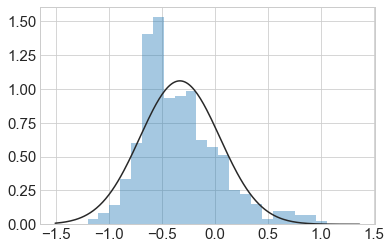

In [12]:
import seaborn as sns
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

sns.set_style("whitegrid")
sns.distplot(psycho_embeddings[:, 0], kde=False, fit=scipy.stats.norm)
plt.show()

In [14]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def find_optimal_num_pca_components(X_mat, min_num_components, max_num_components, interval):
    """Find optimal # of PCA components via cross-validation
    
    Args:
        X_mat: The data matrix, num obs rows with num vars columns
        min_num_components: The minimum number of components to try
        max_num_components: The maximum number of components to try
    
    Returns:
        n_components_pca: The optimal number of components under cross-validation
    """
    n_components = np.arange(min_num_components, max_num_components, interval)
    
    def compute_scores(X):
        pca = PCA(svd_solver='full')
        pca_scores = []
        for n in n_components:
            # Print a few times (5 in this case) during the process of finding PCA components
            if n % 10 == 0:
                print("Running dimensionality reduction for {} components...".format(n))
            pca.n_components = n
            pca_scores.append(np.mean(cross_val_score(pca, X)))
        return pca_scores
    
    # 'compute_scores' Calculates average log-likelihood over all validation-fold samples
    # using Probabilistic Principal Component Analysis model given by 
    # M. Tipping and C. Bishop, Probabilistic Principal Component Analysis, 
    # Journal of the Royal Statistical Society
    pca_cv_scores = compute_scores(X_mat)
    n_components_pca = n_components[np.argmax(pca_cv_scores)]
    print("best n_components by PCA CV = %d" % n_components_pca)
    return n_components_pca, n_components, pca_cv_scores

def plot_pca_scores(best_n_components, n_components_seq, pca_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_components_seq, pca_scores, 'b', label='PCA scores')
    plt.axvline(best_n_components, color='b',
                label='Optimal No. PCs: %d' % best_n_components, linestyle='--')
    plt.xlabel('Number of Principal Components', fontsize=20)
    plt.ylabel('Log-Likelihood on Validation Fold', fontsize=20)
    legend = plt.legend(loc='lower right')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Components in PCA\n' + \
              'via Log-Likelihood with Cross-Validation', fontsize=20)
    plt.show()

Running dimensionality reduction for 20 components...
Running dimensionality reduction for 30 components...
Running dimensionality reduction for 40 components...
best n_components by PCA CV = 37


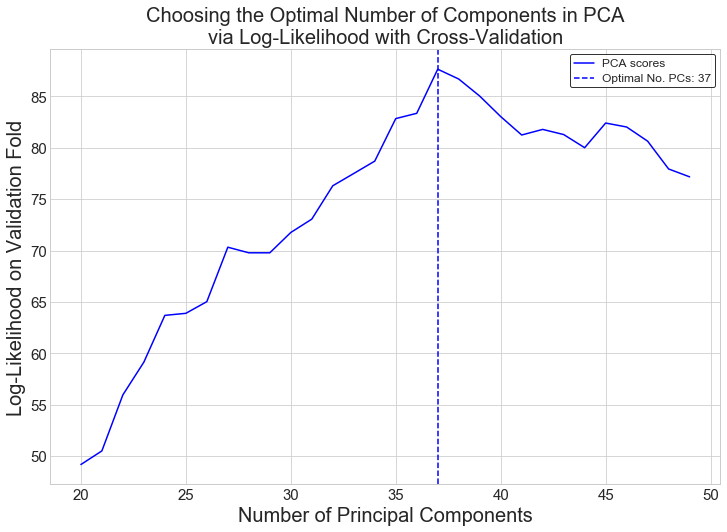

In [20]:
# psycho_best_n_pca_comps = 96
psycho_best_n_pca_comps, n_components_seq, pca_cv_scores = find_optimal_num_pca_components(psycho_embeddings, 
                                                                                           20, 50, 1)
plot_pca_scores(psycho_best_n_pca_comps, n_components_seq, pca_cv_scores)

In [21]:
# embeddings_pca = PCA(n_components=best_n_pca_comps)
# embeddings_pca.fit(embeddings)
# embeddings_pca_scores = embeddings_pca.transform(embeddings)
psycho_embeddings_pca = PCA(n_components=psycho_best_n_pca_comps)
psycho_embeddings_pca.fit(psycho_embeddings)
psycho_embeddings_pca_scores = psycho_embeddings_pca.transform(psycho_embeddings)
# psycho_embeddings_pca.fit(psycho_embeddings_no_dep)
psycho_embeddings_pca_no_dep_scores = psycho_embeddings_pca.transform(psycho_embeddings_no_dep)

# Plotting things in t-SNE Space

In [19]:
# NOTE: Running this code takes a LONG TIME!!! (33,996 samples took ~20 minutes on my local machine)
# from sklearn.manifold import TSNE
# embeddings_tsne = TSNE(n_components=2, verbose=1)
# embeddings_tsne_scores = embeddings_tsne.fit_transform(psycho_embeddings_pca_scores)

In [16]:
# np.save('emotype_tsne_embeddings_v10_all.npy', embeddings_tsne_scores)
# np.save('emotype_original_labels_v10_all.py', psycho_labels)
embeddings_tsne_scores = np.load('emotype_tsne_embeddings_v10_all.npy')
psycho_labels = np.load('emotype_original_labels_v10_all.npy')

In [230]:
def plot_in_tsne_space(tsne_embedded_data, cluster_labels, labels_to_plot, label_to_int_dict,
                       color_map=plt.cm.get_cmap(name='tab10', lut=None).colors):
    """Plot your t-SNE embedded data colored by their corresponding labels
    
    Args:
        tsne_embedded_data: A data matrix n x 2 where n is the number of samples/observations,
            column 1 is the first t-SNE component, and column 2 is the second t-SNE component
        cluster_labels: A data matrix of size n x 1 where n is the number of samples/observations and
            where those lables correspond to tsne_embedded data. Note that the samples can be any 
            string you like. 
        labels_to_plot: A list containing which of the cluster labels in cluster_labels you actually 
            want to plot (we recognize you may not want to plot all the labels at once).
        label_to_int_dict: A dictionary mapping the (str) cluster labels in cluster_labels to discrete 
            integers. These should be consecutive and start from 1 (e.g. 1, 2, 3, ...). These are used
            to map onto color_map [so you can use your dictionary to index into the color map].
        color_map: A tuple of 3-tuples, where each 3-tuple holds the (R, G, B) value of the colors you
            want to use when plotting your data.
    """
    fig, ax = plt.subplots(figsize=(14,10))
    plt.xlabel('t-SNE 1', fontsize=20)
    plt.ylabel('t-SNE 2', fontsize=20)

    plt.title('t-SNE Projection of RNN Embeddings\n' + \
               '(Colored by K-Means Clustering)', fontsize=20)

    for y in labels_to_plot:
        tmp_alpha = 0.7
        ax.scatter(tsne_embedded_data[cluster_labels == y, 0],
                   tsne_embedded_data[cluster_labels == y, 1], 
                   label = y,
                   color = color_map[label_to_int_dict[y]],
                   alpha = tmp_alpha,
                   cmap='tab10')

    ax.grid(False)
    legend = plt.legend(loc='lower right')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    for lh in legend.legendHandles: 
        lh.set_alpha(1)  # https://stackoverflow.com/questions/12848808/set-legend-symbol-opacity-with-matplotlib
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.show()

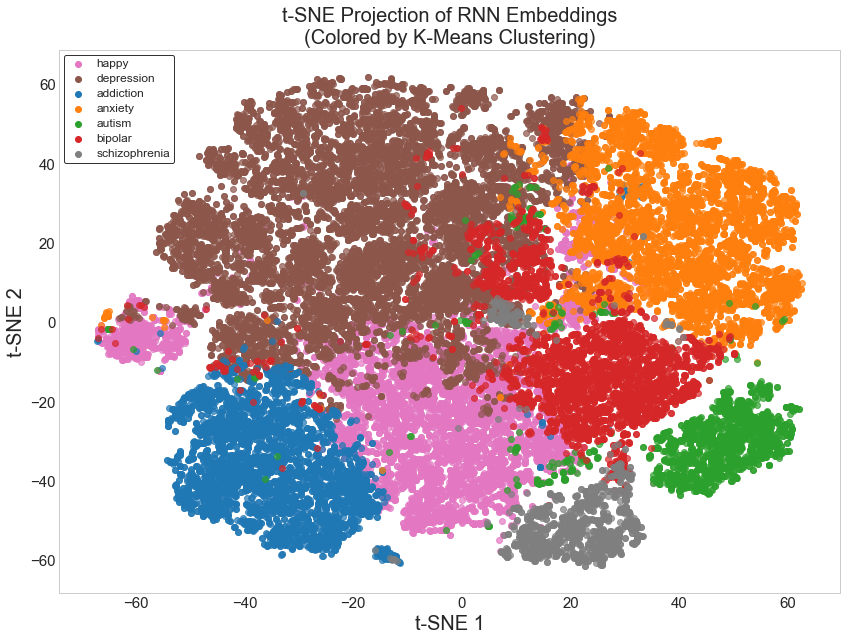

In [231]:
label_cluster_dict = {'addiction':0, 'anxiety':1, 'autism':2, 
                         'bipolar':3, 'conversation':4, 'depression':5, 
                         'happy':6, 'schizophrenia':7}

labels_to_plot = ['happy', 'depression', 'addiction',  # Labels that are first in this list...
                  'anxiety',  'autism', 'bipolar',  # will be in the 'back' of the image and
                  'schizophrenia']  # obscured by labels later in the list
# labels_to_plot = ['depression', 'anxiety', 'bipolar']
# labels_to_plot = ['depression']
plot_in_tsne_space(embeddings_tsne_scores, mapped_cluster_labels, 
                   labels_to_plot, label_cluster_dict)

# K-Means Clustering

In [85]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [86]:
# best_n_clusters = np.where(mean_silhouette_scores == np.max(mean_silhouette_scores))[0][0] + min_num_clusters

In [87]:
def calculate_silhouette_score(X, labels, num_splits=1):
    if num_splits == 1:
        return silhouette_score(X, labels), None
    else:
        N = X.shape[0]
        shuffled_indxs = np.random.choice(N, N)
        splits = np.array_split(shuffled_indxs, num_splits)
        sil_scores = np.zeros((1, num_splits))
        for j in range(num_splits):
            print('\tCalculating silhouette scores for batch {}'.format(j))
            tmp_X = X[splits[j], :]
            tmp_Y = labels[splits[j]]
            sil_scores[0][j] = silhouette_score(tmp_X, tmp_Y)
        mean_silhouette_scores = sil_scores.mean(axis=1)[0]
        std_silhouette_scores = sil_scores.std(axis=1)[0]
        return mean_silhouette_scores, std_silhouette_scores

In [88]:
def cluster_with_DBSCAN(X, eps, min_samples, verbose=False):
    
    print('Starting DBSCAN...')
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    if verbose:
        print("Epsilon: %0.2f" % eps)
        print("Min Samples: %d" % min_samples)
        print('Estimated number of clusters: %d' % n_clusters_)
    
    print(np.unique(labels))
    
    noise_mask = labels != -1
    no_noise_X = X[noise_mask]
    no_noise_labels = labels[noise_mask]
    
    if n_clusters_ <= 1 or np.all(labels == 0) or n_clusters_ > 50:
        print('Conditional 1')
        if verbose:
            print("Silhouette Coefficient = -1\n")
        return n_clusters_, -1
    
    else:
        print('Conditional 2')
        silhouette_avg, silhouette_std = calculate_silhouette_score(no_noise_X, no_noise_labels)
        if verbose:
            print("Silhouette Coefficient: %0.3f\n"
              % silhouette_avg)
        return n_clusters_, silhouette_avg

In [114]:
def test_all_clusterings(X, verbose=False):
    
    epsilons = np.arange(start=1.1,stop=1.5,step=0.05)
    min_samples = range(4, 14)
    
    DBSCAN_result_vectors = []
    
    for m in min_samples:
        for e in epsilons:
            n_clusters, score = cluster_with_DBSCAN(X, e, m, verbose)
            DBSCAN_result_vectors.append([m, e, n_clusters, score])
    
    result = pd.DataFrame(DBSCAN_result_vectors,
                 columns = ['min_num_neighbors', 'epsilon', 
                            'num_clusters', 'score'])
    
    return result

In [115]:
# subtype_cohort_indxs = np.array(psycho_labels) == 'depression'
subtype_cohort_indxs = np.logical_or(psycho_labels == 'depression',
                                     psycho_labels == 'anxiety',
                                     psycho_labels == 'bipolar')
subtype_cohort_embeddings = psycho_embeddings_pca_scores[subtype_cohort_indxs, :]
subtype_cohort_labels = psycho_labels[subtype_cohort_indxs]

In [116]:
cluster_result = test_all_clusterings(subtype_cohort_embeddings, verbose=True)

Starting DBSCAN...
Epsilon: 1.10
Min Samples: 4
Estimated number of clusters: 1
[-1  0]
Conditional 1
Silhouette Coefficient = -1

Starting DBSCAN...
Epsilon: 1.15
Min Samples: 4
Estimated number of clusters: 2
[-1  0  1]
Conditional 2
Silhouette Coefficient: 0.767

Starting DBSCAN...
Epsilon: 1.20
Min Samples: 4
Estimated number of clusters: 2
[-1  0  1]
Conditional 2
Silhouette Coefficient: 0.751

Starting DBSCAN...
Epsilon: 1.25
Min Samples: 4
Estimated number of clusters: 3
[-1  0  1  2]
Conditional 2
Silhouette Coefficient: 0.529

Starting DBSCAN...
Epsilon: 1.30
Min Samples: 4
Estimated number of clusters: 2
[-1  0  1]
Conditional 2
Silhouette Coefficient: 0.692

Starting DBSCAN...
Epsilon: 1.35
Min Samples: 4
Estimated number of clusters: 2
[-1  0  1]
Conditional 2
Silhouette Coefficient: 0.684

Starting DBSCAN...
Epsilon: 1.40
Min Samples: 4
Estimated number of clusters: 2
[-1  0  1]
Conditional 2
Silhouette Coefficient: 0.670

Starting DBSCAN...
Epsilon: 1.45
Min Samples: 4
Es

In [124]:
cluster_result.to_csv("dbscan_cluster_result.csv")

In [120]:
cluster_result

,min_num_neighbors,epsilon,num_clusters,score
0,4,1.10,1,-1.000000
1,4,1.15,2,0.766988
2,4,1.20,2,0.750835
3,4,1.25,3,0.528948
4,4,1.30,2,0.691894
5,4,1.35,2,0.684387
6,4,1.40,2,0.669518
7,4,1.45,2,0.661479
8,5,1.10,1,-1.000000
9,5,1.15,1,-1.000000


In [121]:
cluster_result.loc[cluster_result['score'] == np.max(cluster_result['score'])]

,min_num_neighbors,epsilon,num_clusters,score
1,4,1.15,2,0.766988


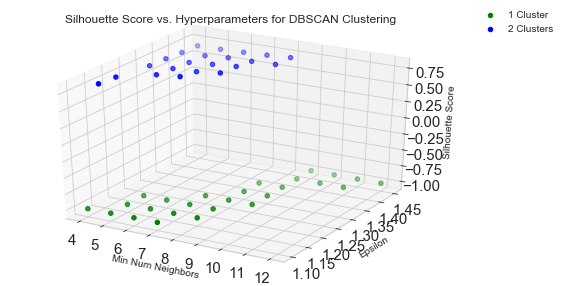

In [119]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

eps1 = cluster_result.loc[cluster_result['score'] == 0, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['score'] == 0, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['score'] == 0, 'score']

eps1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'score']

eps2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'epsilon']
neighbors2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 
                                'min_num_neighbors']
scores2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'score']


ax.scatter(neighbors1,eps1,scores1,c='g',marker='o', label = '1 Cluster')
ax.scatter(neighbors2,eps2,scores2,c='b',marker='o', label = '2 Clusters')

ax.set_xlabel('Min Num Neighbors')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Silhouette Score')

plt.title('Silhouette Score vs. Hyperparameters for DBSCAN Clustering')

handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.set_style("whitegrid")
plt.show()

In [259]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cross_validation import KFold
def calculate_kmeans_cluster_labels(X, min_num_clusters=2, max_num_clusters=15,
                                    num_splits=10):
    N = X.shape[0]
    shuffled_indxs = np.random.choice(N, N)
    num_clusters_to_try = np.arange(min_num_clusters, max_num_clusters)
    splits = np.array_split(shuffled_indxs, num_splits)
    sil_scores = np.zeros((num_clusters_to_try.shape[0], num_splits))
    for n_clusters in num_clusters_to_try:
        print('Testing {} clusters...'.format(n_clusters))
        clusterer = MiniBatchKMeans(init='k-means++', 
                                   n_clusters=n_clusters, 
                                   batch_size=1000,
                                   n_init=10,
                                   max_no_improvement=20,
                                   random_state=42, # What's the meaning of life?
                                   verbose=0)
        tmp_cluster_labels = clusterer.fit_predict(X)
        for j in range(num_splits):
            tmp_X = X[splits[j], :]
            tmp_Y = tmp_cluster_labels[splits[j]]
            sil_scores[n_clusters - min_num_clusters][j] = silhouette_score(tmp_X, tmp_Y)
    mean_silhouette_scores = sil_scores.mean(axis=1)
    std_silhouette_scores = sil_scores.std(axis=1)
    best_n_clusters = np.where(mean_silhouette_scores == np.max(mean_silhouette_scores))[0][0] + min_num_clusters
    return mean_silhouette_scores, std_silhouette_scores, n_comps_seq, best_n_clusters

In [260]:
# np.save('kmeans_labels.npy', tmp_cluster_labels)

In [266]:
# subtype_cohort_indxs = np.array(psycho_labels) == 'depression'
subtype_cohort_indxs = np.logical_or(psycho_labels == 'depression',
                                     psycho_labels == 'anxiety',
                                     psycho_labels == 'bipolar')
subtype_cohort_embeddings = psycho_embeddings_pca_scores[subtype_cohort_indxs, :]
subtype_cohort_labels = psycho_labels[subtype_cohort_indxs]

Testing 2 clusters...
Testing 3 clusters...
Testing 4 clusters...
Testing 5 clusters...
Testing 6 clusters...
Testing 7 clusters...
Testing 8 clusters...
Testing 9 clusters...
Testing 10 clusters...
Testing 11 clusters...
Testing 12 clusters...
Testing 13 clusters...
Testing 14 clusters...


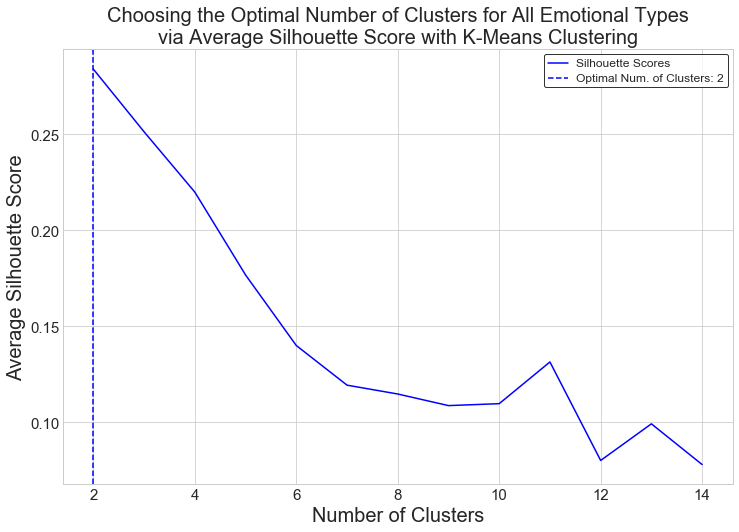

In [267]:
kmeans_results = calculate_kmeans_cluster_labels(subtype_cohort_embeddings)
sil_scores, std_scores, n_seq, best_n_kmeans = kmeans_results
plot_silhouette_scores(best_n_kmeans, n_seq, sil_scores)

In [263]:
clusterer = MiniBatchKMeans(init='k-means++', 
                               n_clusters=7, 
                               batch_size=1000,
                               n_init=10,
                               max_no_improvement=20,
                               random_state=42, # What's the meaning of life?
                               verbose=0)
tmp_cluster_labels = clusterer.fit_predict(psycho_embeddings_pca_scores)
str_cluster_labels = ['Cluster ' + str(i) for i in tmp_cluster_labels]

In [217]:
# tmp_cluster_labels = np.array([str(i) for i in tmp_cluster_labels])

In [264]:
from sklearn.metrics import confusion_matrix
lookupTable, tmp_true_labels_int = np.unique(psycho_labels, return_inverse=True)
cf_matrix = confusion_matrix(tmp_true_labels_int, tmp_cluster_labels)
cluster_order = np.argsort(np.argmax(cf_matrix, axis=1))
cf_matrix = cf_matrix[cluster_order, :]
print(cf_matrix)

[[14265   426  4676  1355   351   247  1164]
 [   50  4566   322    38    16     4    26]
 [   22     5   728    27     0     7    12]
 [  299    59  1126  5079    44    54   110]
 [    1     0    64     2  1229     0     5]
 [    9     0   131    23     0  1909     6]
 [  312    27   788   133   101    23  3046]]


In [219]:
np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)

0.718679320073682

In [220]:
np.bincount(tmp_true_labels_int)
np.mean(tmp_true_labels_int == 1)

0.1578800102595192

In [203]:
mapped_cluster_labels_int = np.array([cluster_order[k] for k in tmp_cluster_labels])

In [224]:
mapped_cluster_labels = lookupTable[mapped_cluster_labels_int]

In [227]:
np.mean(mapped_cluster_labels_int == tmp_true_labels_int)

0.718679320073682

In [226]:
np.mean(mapped_cluster_labels == psycho_labels)

0.718679320073682

In [205]:
for first_emo_label in np.unique(psycho_labels):
    print('For posts originally under \'{}\'...'.format(first_emo_label))
    first_emo_indx = np.where(lookupTable == first_emo_label)
    for second_emo_label in np.unique(psycho_labels):
        second_emo_indx = np.where(lookupTable == second_emo_label)
        overlap = np.sum(np.logical_and(tmp_true_labels_int == first_emo_indx, 
                                        mapped_cluster_labels_int == second_emo_indx))
        percent_overlap = overlap / np.sum(tmp_true_labels_int == first_emo_indx)
        print('\t{}% were classified as {}'.format(percent_overlap * 100, second_emo_label))

For posts originally under 'addiction'...
	90.91995221027479% were classified as addiction
	0.7566706491437674% were classified as anxiety
	0.07964954201513341% were classified as autism
	0.5177220230983672% were classified as bipolar
	0.9956192751891677% were classified as depression
	6.4117881322182395% were classified as happy
	0.31859816806053365% were classified as schizophrenia
For posts originally under 'anxiety'...
	0.8713631664451337% were classified as addiction
	75.01107665042092% were classified as anxiety
	0.7975188303057155% were classified as autism
	1.6245753950671984% were classified as bipolar
	4.4158913011372025% were classified as depression
	16.629744498596956% were classified as happy
	0.6498301580268794% were classified as schizophrenia
For posts originally under 'autism'...
	0.0% were classified as addiction
	1.1068334937439845% were classified as anxiety
	91.86717998075072% were classified as autism
	0.28873917228103946% were classified as bipolar
	0.4331087584

In [101]:
def plot_silhouette_scores(best_n_clusters, n_comps_seq, sil_scores):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(n_comps_seq, sil_scores, 'b', label='Silhouette Scores')
    plt.axvline(best_n_clusters, color='b',
                label='Optimal Num. of Clusters: %d' % best_n_clusters, linestyle='--')
    plt.xlabel('Number of Clusters', fontsize=20)
    plt.ylabel('Average Silhouette Score', fontsize=20)
    legend = plt.legend(loc='best')
    legend = plt.legend(frameon = 1)
    for txt in legend.get_texts():
        txt.set_size('large')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    # plt.setp(frame.get_texts(), fontsize='12')
    plt.title('Choosing the Optimal Number of Clusters for All Emotional Types\n' + \
              'via Average Silhouette Score with K-Means Clustering', fontsize=20)
    plt.show()

# Old K-Means Code (SLOW)

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# n_optimal_clusters_kmeans, n_components_seq, sil_scores

def find_optimal_num_clusters_kmeans(X, min_num_clusters=2, max_num_clusters=12):
    n_components_seq = range(min_num_clusters, max_num_clusters)
    n_optimal_clusters_kmeans = 0
    silhouette_scores = []
    best_cluster_labels = []
    best_sil_score = -np.infty
    for n_clusters in n_components_seq:
        print('Running K-Means for {} Clusters...'.format(n_clusters))
        clusterer = KMeans(init='k-means++', 
                           n_clusters=n_clusters, 
                           batch_size=1000,
                           n_init=10,
                           max_no_improvement=20,
                           random_state=42, # What's the meaning of life?
                           verbose=1)
        tmp_cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, tmp_cluster_labels)
        if silhouette_avg > best_sil_score:
            best_sil_score = silhouette_avg
            best_cluster_labels = tmp_cluster_labels
            n_optimal_clusters_kmeans = n_clusters
        silhouette_scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "the average silhouette_score is :", silhouette_avg)
    return n_optimal_clusters_kmeans, best_cluster_labels, n_components_seq, silhouette_scores

In [ ]:
n_kmeans, cluster_labels, n_comps_seq, sil_scores = find_optimal_num_clusters_kmeans(psycho_embeddings_pca_scores)